# Udacity Deep Learning Project - Digit Recognition - Part 1

Author: Lei Mao <br>
Late revised on: 12/28/2016 <br>

## SVHN Dataset Preparation

### Import libraries quired

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import sys
import tarfile
import gzip
import h5py # read .mat files
from scipy import ndimage
from sklearn.model_selection import train_test_split
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
%autosave 0

Autosave disabled


### Download SVHN dataset

Download SVHN dataset from http://ufldl.stanford.edu/housenumbers/

In [3]:
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 1% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)
    
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
            
        last_percent_reported = percent

def maybe_download(filename, expected_bytes, url, destination_folder, force = False):
    """Download a file if not present, and make sure it's the right size."""
    filename_real = destination_folder + filename
    if force or not os.path.exists(filename_real):
        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)
        print('Attempting to download:', filename) 
        filename_real, _ = urlretrieve(url + filename, filename_real, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename_real)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename_real

In [4]:
url_SVHN = 'http://ufldl.stanford.edu/housenumbers/'
SVHN_folder = 'data/SVHN/'

train_filename = maybe_download(filename = 'train.tar.gz', expected_bytes = 404141560, 
                                url = url_SVHN, destination_folder = SVHN_folder)
test_filename = maybe_download(filename = 'test.tar.gz', expected_bytes = 276555967, 
                               url = url_SVHN, destination_folder = SVHN_folder)
extra_filename = maybe_download(filename = 'extra.tar.gz', expected_bytes = 1955489752, 
                                url = url_SVHN, destination_folder = SVHN_folder)

('Found and verified', 'train.tar.gz')
('Found and verified', 'test.tar.gz')
('Found and verified', 'extra.tar.gz')


### Exact SVHN labelset

See http://stackoverflow.com/questions/27670149/read-matlab-v7-3-file-into-python-list-of-numpy-arrays-via-h5py for h5py load and read troubleshooting.

In [5]:
def maybe_extract(filename, dest_folder, force = False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(path = dest_folder)
        tar.close()
    return root + '/'

In [6]:
train_folders = maybe_extract(filename = train_filename, dest_folder = SVHN_folder)
test_folders = maybe_extract(filename = test_filename, dest_folder = SVHN_folder)
extra_folders = maybe_extract(filename = extra_filename, dest_folder = SVHN_folder)

data/SVHN/train already present - Skipping extraction of data/SVHN/train.tar.gz.
data/SVHN/test already present - Skipping extraction of data/SVHN/test.tar.gz.
data/SVHN/extra already present - Skipping extraction of data/SVHN/extra.tar.gz.


In [7]:
def array2string(array):
    string = ''
    for i in array:
        string += chr(i)
    return string

In [8]:
def get_name(fhand, index):
    '''Get the name of indexed image from h5py loaded mat files'''
    '''The return is a string'''
    image_name = fhand[fhand['digitStruct']['name'][index][0]].value
    image_name = image_name.reshape(len(image_name))
    image_name = array2string(image_name)
    return image_name

def get_attribute(fhand, index, attribute):
    '''Get the attribute of indexed image from h5py loaded mat files'''
    '''The return is one-dimensional numpy array'''
    attribute_array = fhand[fhand['digitStruct']['bbox'][index][0]][attribute].value
    attribute_array = attribute_array.reshape(len(attribute_array))
    attribute_list = list()
    if len(attribute_array) <= 1:
        attribute_list = np.array(attribute_array, dtype = np.int)
        return attribute_list
    else:
        for i in attribute_array:
            attribute_list.append(fhand[i].value.reshape(1))
        attribute_list = np.array(attribute_list, dtype = np.int)
        attribute_list = attribute_list.reshape(len(attribute_list))
        return attribute_list

In [9]:
def label_extraction(file_path, numDigits_max, dataformat = 'png'):
    '''Extract label information from 'digitStruct.mat' file using h5py package'''
    with h5py.File(file_path,'r') as f:
        numImages = len(f['digitStruct']['bbox'])
        # Initialize all the attribute matrix to matrix filled with 0
        heights = np.full(shape = (numImages, numDigits_max), fill_value = 0, dtype = int)
        lefts = np.full(shape = (numImages, numDigits_max), fill_value = 0, dtype = int)
        tops = np.full(shape = (numImages, numDigits_max), fill_value = 0, dtype = int)
        widths = np.full(shape = (numImages, numDigits_max), fill_value = 0, dtype = int)
        # The label format according to the introduction of SVHN dataset: 0 - 9 was labeled with 1 - 10 respectively
        # So we can initialize the matrix full of zeros
        labels = np.full(shape = (numImages, numDigits_max), fill_value = 0, dtype = int)
        # Numpy array to store image index
        names = np.zeros(shape = numImages, dtype = int)
        # Count number of warning messages
        warning_count = 0
        print('Processing file: %s...' %(file_path))
        print('This may take a while.')
        for i in xrange(numImages):
            if i % 1000 == 0:
                print('Image labels processed: %d, %.1f%%.' % (i, float(i) / numImages * 100))
            # Get attributes
            height = get_attribute(fhand = f, index = i, attribute = 'height')
            left = get_attribute(fhand = f, index = i, attribute = 'left')
            top = get_attribute(fhand = f, index = i, attribute = 'top')
            width = get_attribute(fhand = f, index = i, attribute = 'width')
            label = get_attribute(fhand = f, index = i, attribute = 'label')
            name = get_name(fhand = f, index = i)
            # Routine check
            if len(height) > numDigits_max:
                print('Warning: number of elements in height exceed numDigits_max assigned.')
                warning_count += 1
            if len(left) > numDigits_max:
                print('Warning: number of elements in left exceed numDigits_max assigned.')
                warning_count += 1
            if len(top) > numDigits_max:
                print('Warning: number of elements in top exceed numDigits_max assigned.')   
                warning_count += 1
            if len(width) > numDigits_max:
                print('Warning: number of elements in width exceed numDigits_max assigned.')
                warning_count += 1
            if len(height) > numDigits_max:
                print('Warning: number of elements in height exceed numDigits_max assigned.') 
                warning_count += 1
            if name.split('.')[1] != dataformat:
                print('Warning: image file name does not end with %s.' % dataformat) 
                warning_count += 1
            # Put attributes to corresponding matrix
            heights[i][0:len(height)] = height
            lefts[i][0:len(left)] = left
            tops[i][0:len(top)] = top
            widths[i][0:len(width)] = width
            labels[i][0:len(label)] = label
            names[i] = int(name.split('.')[0])
            
    if warning_count != 0:
        print('There might be problems during label extraction.')
    print('Label extraction finished.')
    print('Total number of image labels processed: %d.' % numImages)
    
    labelset = {'names': names, 'labels': labels, 'heights': heights, 'lefts': lefts, 'tops': tops, 'widths': widths}
    
    return labelset

In [10]:
def maybe_labelset_pickle(file_path, numDigits_max, set_filename, destination_folder, force = False, dataformat = 'png'):
    '''Store labelset to pickle file'''
    '''labelset has to be in dictionary format'''
    filename_real = destination_folder + set_filename + '.pickle'
    filename = set_filename + '.pickle'
    if os.path.exists(filename_real) and not force:
        print('%s already present - Skipping pickling.' %filename)
    else:
        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)
        print('Pickling %s.' %set_filename)
        try:
            with open(filename_real, 'wb') as f:
                labelset = label_extraction(
                    file_path = file_path, numDigits_max = numDigits_max, dataformat = dataformat)
                pickle.dump(labelset, f, pickle.HIGHEST_PROTOCOL)
            print(filename + ' saved' + ' successfully')
        except Exception as e:
            print('Unable to save data to', filename, ':', e)
    return filename_real

In [11]:
labels_filename = 'digitStruct.mat'
numDigits_max = 6

train_labelset_path = maybe_labelset_pickle(file_path = train_folders + labels_filename, numDigits_max = numDigits_max, 
                                            set_filename = 'train_labelset', destination_folder = SVHN_folder, 
                                            force = False, dataformat = 'png')

test_labelset_path = maybe_labelset_pickle(file_path = test_folders + labels_filename, numDigits_max = numDigits_max, 
                                           set_filename = 'test_labelset', destination_folder = SVHN_folder, 
                                           force = False, dataformat = 'png')

extra_labelset_path = maybe_labelset_pickle(file_path = extra_folders + labels_filename, numDigits_max = numDigits_max, 
                                            set_filename = 'extra_labelset', destination_folder = SVHN_folder, 
                                            force = False, dataformat = 'png')

train_labelset.pickle already present - Skipping pickling.
test_labelset.pickle already present - Skipping pickling.
extra_labelset.pickle already present - Skipping pickling.


### Define digit sequence bounding box algorithm

In [12]:
def load_pickle(file_path):
    '''Load data from pickle file'''
    with open(file_path, 'rb') as f:
        save = pickle.load(f)
    return save

In [13]:
train_labelset = load_pickle(train_labelset_path)
test_labelset = load_pickle(test_labelset_path)
extra_labelset = load_pickle(extra_labelset_path)

In [14]:
print('The train_labelset contains:', train_labelset.keys())
print('The test_labelset contains:', test_labelset.keys())
print('The extra_labelset contains:', extra_labelset.keys())

('The train_labelset contains:', ['lefts', 'widths', 'labels', 'tops', 'heights', 'names'])
('The test_labelset contains:', ['lefts', 'widths', 'labels', 'tops', 'heights', 'names'])
('The extra_labelset contains:', ['lefts', 'widths', 'labels', 'tops', 'heights', 'names'])


In [15]:
def bounding_box(image_size, labels, lefts, tops, heights, widths, expansion = 0., seed = 0):
    '''This is an algorithm to select a digit sequence bounding box given the image and single digit bounding box'''
    '''Author: Lei Mao'''
    
    # The algorithm has random process. Include random seed here.
    np.random.seed(seed=seed)
    
    sequence_length = np.sum(labels > 0)
    
    topleft_x = lefts[0: sequence_length]
    topleft_y = tops[0: sequence_length]
    height_elements = heights[0: sequence_length]
    width_elements = widths[0: sequence_length]
    bottomright_x = topleft_x + width_elements
    bottomright_y = topleft_y + height_elements
    
    # Correct the parameters
    for i in xrange(sequence_length):
        if topleft_x[i] < 0:
            topleft_x[i] = 0
        if topleft_y[i] < 0:
            topleft_y[i] = 0
        if bottomright_x[i] > image_size[1] - 1:
            bottomright_x[i] = image_size[1] - 1
        if bottomright_y[i] > image_size[0] - 1:
            bottomright_y[i] = image_size[0] - 1
    
    height_elements = bottomright_y - topleft_y
    width_elements = bottomright_x - topleft_x

    # Find the topleft and bottomright coordinates of the minimal bounding box
    box_min_topleft_x = np.amin(topleft_x)
    box_min_topleft_y = np.amin(topleft_y)
    box_min_bottomright_x = np.amax(bottomright_x)
    box_min_bottomright_y = np.amax(bottomright_y)
    
    # Expand the minimal bounding box by expansion
    box_min_height = box_min_bottomright_y - box_min_topleft_y
    box_min_width = box_min_bottomright_x - box_min_topleft_x
    
    box_expanded_height = int(box_min_height * (1. + expansion))
    box_expanded_width = int(box_min_width * (1. + expansion))
    
    if box_expanded_height >= image_size[0]:
        # After expansion, if the expanded box height is larger than the original image height
        # Use the original original image height for the expanded box
        box_expanded_topleft_y = 0
        box_expanded_bottomright_y = image_size[0]
    else:
        '''box_min_topleft_y >= box_expanded_topleft_y >= 0'''
        '''image_size[0] - box_expanded_height >= box_expanded_topleft_y >= box_min_bottomright_y - box_expanded_height'''
        # Randomly select a expanded box that contains the minimal box
        box_expanded_topleft_y = np.random.randint(
            low = np.amax([0, box_min_bottomright_y - box_expanded_height]), 
            high = np.amin([box_min_topleft_y, image_size[0] - box_expanded_height]) + 1)
        box_expanded_bottomright_y = box_expanded_topleft_y + box_expanded_height
    
    if box_expanded_width >= image_size[1]:
        box_expanded_topleft_x = 0
        box_expanded_bottomright_x = image_size[1]       
    else:
        '''box_min_topleft_x >= box_expanded_topleft_x >= 0'''
        '''image_size[1] - box_expanded_width + 1 >= box_expanded_topleft_x >= box_min_bottomright_x - box_expanded_width + 1'''
        box_expanded_topleft_x = np.random.randint(
            low = np.amax([0, box_min_bottomright_x - box_expanded_width]), 
            high = np.amin([box_min_topleft_x, image_size[1] - box_expanded_width]) + 1)
        box_expanded_bottomright_x = box_expanded_topleft_x + box_expanded_width
    return (box_expanded_topleft_x, box_expanded_topleft_y), (box_expanded_bottomright_x, box_expanded_bottomright_y)

In [16]:
def bounding_box_test(labelset, dataset_path, image_index, expansion = 0., seed = 0):
    '''Test the bounding box algorithm in training dataset'''
    image_path = dataset_path + str(image_index + 1) + '.png'
    img = cv2.imread(image_path)
    # Plot single digit bounding box
    sequence_length = np.sum(labelset['labels'][image_index] > 0)
    topleft_x = labelset['lefts'][image_index][0: sequence_length]
    topleft_y = labelset['tops'][image_index][0: sequence_length]
    height_elements = labelset['heights'][image_index][0: sequence_length]
    width_elements = labelset['widths'][image_index][0: sequence_length]
    bottomright_x = topleft_x + width_elements
    bottomright_y = topleft_y + height_elements
    # Plot single digit bounding box
    for i in xrange(len(topleft_x)):
        cv2.rectangle(img, (topleft_x[i], topleft_y[i]), (bottomright_x[i], bottomright_y[i]), (255,0,0), 1)
    # Plot expanded digit sequence bounding box
    topleft, bottomright = bounding_box(image_size = img.shape, labels = labelset['labels'][image_index], 
                                        lefts = labelset['lefts'][image_index], tops = labelset['tops'][image_index], 
                                        heights = labelset['heights'][image_index], 
                                        widths = labelset['widths'][image_index], expansion = expansion, seed = seed)
    cv2.rectangle(img, topleft, bottomright, (0,255,0), 1)
    fig = plt.figure()
    plotwindow = fig.add_subplot(111)
    plt.imshow(img)
    plt.show()

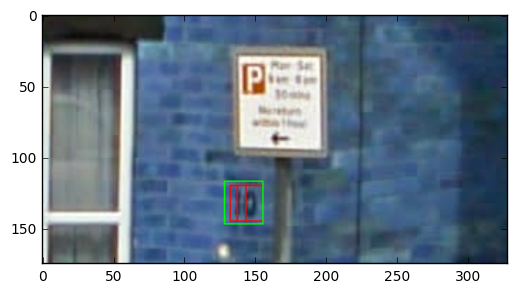

In [17]:
bounding_box_test(labelset = test_labelset, dataset_path = SVHN_folder + 'test/', 
                  image_index = 111, expansion = 0.2, seed = 3)

Therefore, it seems that the bounding box algorithm is working. It should be noted that this algorithm also works for the digit sequence that is vertically aligned or is not even aligned.

### Crop and resize SVHN images

In [18]:
def image_preprocessing(labelset, dataset_path, size = 32, num_shifts = 1, expansion = 0., num_channels = 3):
    '''This image preprocessing contains several steps: 
    1. Define certain numbers of sequence bounding box that contains all the digits in the image;
    2. Resize the image to square with certain size.'''
    
    num_images = len(labelset['names'])
    dataset_processed = np.zeros(shape = (num_images * num_shifts, size, size, num_channels), dtype = np.uint8)
    labels_processed = np.zeros(shape = (num_images * num_shifts, labelset['labels'].shape[1]), dtype = np.uint8)
    
    print('Start to preprocess dataset: %s' % dataset_path)
    
    for i in xrange(num_images):
        if i % 1000 == 0:
            print('Image processed: %d, %.1f%%.' % (i, float(i) / num_images * 100))

        image_path = dataset_path + str(labelset['names'][i]) + '.png'
        img = cv2.imread(image_path)
        # Generate shifted version of images
        for j in xrange(num_shifts):
            topleft, bottomright = bounding_box(image_size = img.shape, labels = labelset['labels'][i], 
                                                lefts = labelset['lefts'][i], tops = labelset['tops'][i], 
                                                heights = labelset['heights'][i], widths = labelset['widths'][i], 
                                                expansion = expansion, seed = j)
            img_cropped = img[topleft[1]:bottomright[1], topleft[0]:bottomright[0]]
            img_resized = cv2.resize(img_cropped, (size, size)) # Here we use default interpolation method
            dataset_processed[i * num_shifts + j] = img_resized
            labels_processed[i * num_shifts + j] = labelset['labels'][i]
    
    print('Preprocess completed.')
            
    return dataset_processed, labels_processed

In [19]:
def maybe_processed_dataset_pickle(dataset_path, labelset, set_filename, destination_folder, size, 
                                   num_shifts = 1, expansion = 0., num_channels = 3, force = False):
    '''Store dataset and labels to pickle file'''
    '''There is a well-known pickle bug in cPickle in python 2.7 reporting 
    SystemError('error return without exception set') which may happen in this dataset'''
    filename_real = destination_folder + set_filename + '.pickle'
    filename = set_filename + '.pickle'
    if os.path.exists(filename_real) and not force:
        print('%s already present - Skipping pickling.' %filename)
    else:
        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)
        print('Pickling %s.' %set_filename)
        try:
            dataset = image_preprocessing(labelset = labelset, dataset_path = dataset_path, size = size, 
                                          num_shifts = num_shifts, expansion = expansion, num_channels = num_channels)
            with open(filename_real, 'wb') as f:
                save = {
                    'dataset': dataset,
                    'labels': labelset['labels']
                }
                pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
            print(filename + ' saved' + ' successfully')
        except Exception as e:
            print('Unable to save data to', filename, ':', e)
    return filename_real

In [20]:
def maybe_pickle(dataset, labels, set_filename, destination_folder, force = False):
    '''Store dataset and labels to pickle file'''
    filename_real = destination_folder + set_filename + '.pickle'
    filename = set_filename + '.pickle'
    if os.path.exists(filename_real) and not force:
        print('%s already present - Skipping pickling.' %filename)
    else:
        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)
        print('Pickling %s.' %set_filename)
        try:
            with open(filename_real, 'wb') as f:
                save = {
                    'dataset': dataset,
                    'labels': labels
                }
                pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
            print(filename + ' saved' + ' successfully')
        except Exception as e:
            print('Unable to save data to', filename, ':', e)
    return filename_real

In [21]:
num_shifts = 3
expansion = 0.3
image_size = 32

train_dataset_processed, train_labels_processed = image_preprocessing(
    labelset = train_labelset, dataset_path = SVHN_folder + 'train/', size = image_size, 
    num_shifts = num_shifts, expansion = expansion, num_channels = 3)

Start to preprocess dataset: data/SVHN/train/
Image processed: 0, 0.0%.
Image processed: 1000, 3.0%.
Image processed: 2000, 6.0%.
Image processed: 3000, 9.0%.
Image processed: 4000, 12.0%.
Image processed: 5000, 15.0%.
Image processed: 6000, 18.0%.
Image processed: 7000, 21.0%.
Image processed: 8000, 24.0%.
Image processed: 9000, 26.9%.
Image processed: 10000, 29.9%.
Image processed: 11000, 32.9%.
Image processed: 12000, 35.9%.
Image processed: 13000, 38.9%.
Image processed: 14000, 41.9%.
Image processed: 15000, 44.9%.
Image processed: 16000, 47.9%.
Image processed: 17000, 50.9%.
Image processed: 18000, 53.9%.
Image processed: 19000, 56.9%.
Image processed: 20000, 59.9%.
Image processed: 21000, 62.9%.
Image processed: 22000, 65.9%.
Image processed: 23000, 68.9%.
Image processed: 24000, 71.9%.
Image processed: 25000, 74.8%.
Image processed: 26000, 77.8%.
Image processed: 27000, 80.8%.
Image processed: 28000, 83.8%.
Image processed: 29000, 86.8%.
Image processed: 30000, 89.8%.
Image proc

In [22]:
maybe_pickle(dataset = train_dataset_processed, labels = train_labels_processed, set_filename = 'train_set', 
             destination_folder = SVHN_folder, force = False)

Pickling train_set.
train_set.pickle saved successfully


'data/SVHN/train_set.pickle'

In [23]:
num_shifts = 3
expansion = 0.3
image_size = 32

extra_dataset_processed, extra_labels_processed = image_preprocessing(
    labelset = extra_labelset, dataset_path = SVHN_folder + 'extra/', size = image_size, 
    num_shifts = num_shifts, expansion = expansion, num_channels = 3)

Start to preprocess dataset: data/SVHN/extra/
Image processed: 0, 0.0%.
Image processed: 1000, 0.5%.
Image processed: 2000, 1.0%.
Image processed: 3000, 1.5%.
Image processed: 4000, 2.0%.
Image processed: 5000, 2.5%.
Image processed: 6000, 3.0%.
Image processed: 7000, 3.5%.
Image processed: 8000, 4.0%.
Image processed: 9000, 4.4%.
Image processed: 10000, 4.9%.
Image processed: 11000, 5.4%.
Image processed: 12000, 5.9%.
Image processed: 13000, 6.4%.
Image processed: 14000, 6.9%.
Image processed: 15000, 7.4%.
Image processed: 16000, 7.9%.
Image processed: 17000, 8.4%.
Image processed: 18000, 8.9%.
Image processed: 19000, 9.4%.
Image processed: 20000, 9.9%.
Image processed: 21000, 10.4%.
Image processed: 22000, 10.9%.
Image processed: 23000, 11.4%.
Image processed: 24000, 11.9%.
Image processed: 25000, 12.4%.
Image processed: 26000, 12.8%.
Image processed: 27000, 13.3%.
Image processed: 28000, 13.8%.
Image processed: 29000, 14.3%.
Image processed: 30000, 14.8%.
Image processed: 31000, 15.

In [24]:
maybe_pickle(dataset = extra_dataset_processed, labels = extra_labels_processed, set_filename = 'extra_set', 
             destination_folder = SVHN_folder, force = False)

Pickling extra_set.
extra_set.pickle saved successfully


'data/SVHN/extra_set.pickle'

In [25]:
'''
# Split the training dataset into num_sub sub-datasets
num_sub = 2
start = 0
for i in xrange(num_sub):
    maybe_pickle(dataset = train_dataset_processed[start: start + len(train_dataset_processed) // num_sub], 
                 labels = train_labels_processed[start: start + len(train_dataset_processed) // num_sub], 
                 set_filename = 'train_set_' + str(i), destination_folder = SVHN_folder, force = False)
    start += len(train_dataset_processed) // num_sub
'''

"\n# Split the training dataset into num_sub sub-datasets\nnum_sub = 2\nstart = 0\nfor i in xrange(num_sub):\n    maybe_pickle(dataset = train_dataset_processed[start: start + len(train_dataset_processed) // num_sub], \n                 labels = train_labels_processed[start: start + len(train_dataset_processed) // num_sub], \n                 set_filename = 'train_set_' + str(i), destination_folder = SVHN_folder, force = False)\n    start += len(train_dataset_processed) // num_sub\n"

In [26]:
'''
num_shifts = 2
expansion = 0.3
image_size = 32

# Here I set num_shifts = 1 because of the limitation of my desktop
extra_dataset_processed, extra_labels_processed = image_preprocessing(
    labelset = extra_labelset, dataset_path = SVHN_folder + 'extra/', size = image_size, 
    num_shifts = num_shifts, expansion = expansion, num_channels = 3)
'''

"\nnum_shifts = 2\nexpansion = 0.3\nimage_size = 32\n\n# Here I set num_shifts = 1 because of the limitation of my desktop\nextra_dataset_processed, extra_labels_processed = image_preprocessing(\n    labelset = extra_labelset, dataset_path = SVHN_folder + 'extra/', size = image_size, \n    num_shifts = num_shifts, expansion = expansion, num_channels = 3)\n"

In [27]:
'''
num_sub = 5
start = 0
for i in xrange(num_sub):
    maybe_pickle(dataset = extra_dataset_processed[start: start + len(extra_dataset_processed) // num_sub], 
                 labels = extra_labels_processed[start: start + len(extra_dataset_processed) // num_sub], 
                 set_filename = 'extra_set_' + str(i), destination_folder = SVHN_folder, force = False)
    start += len(extra_dataset_processed) // num_sub
'''

"\nnum_sub = 5\nstart = 0\nfor i in xrange(num_sub):\n    maybe_pickle(dataset = extra_dataset_processed[start: start + len(extra_dataset_processed) // num_sub], \n                 labels = extra_labels_processed[start: start + len(extra_dataset_processed) // num_sub], \n                 set_filename = 'extra_set_' + str(i), destination_folder = SVHN_folder, force = False)\n    start += len(extra_dataset_processed) // num_sub\n"

In [28]:
'''
del extra_dataset_processed
del extra_labels_processed
'''

'\ndel extra_dataset_processed\ndel extra_labels_processed\n'

In [29]:
image_size = 32

# There is no num_shifts and expansion for test dataset
test_dataset_processed, test_labels_processed = image_preprocessing(
    labelset = test_labelset, dataset_path = SVHN_folder + 'test/', size = image_size, 
    num_shifts = 1, expansion = 0., num_channels = 3)

Start to preprocess dataset: data/SVHN/test/
Image processed: 0, 0.0%.
Image processed: 1000, 7.7%.
Image processed: 2000, 15.3%.
Image processed: 3000, 23.0%.
Image processed: 4000, 30.6%.
Image processed: 5000, 38.3%.
Image processed: 6000, 45.9%.
Image processed: 7000, 53.6%.
Image processed: 8000, 61.2%.
Image processed: 9000, 68.9%.
Image processed: 10000, 76.5%.
Image processed: 11000, 84.2%.
Image processed: 12000, 91.8%.
Image processed: 13000, 99.5%.
Preprocess completed.


In [30]:
maybe_pickle(dataset = test_dataset_processed, labels = test_labels_processed, set_filename = 'test_set', 
             destination_folder = SVHN_folder, force = False)

Pickling test_set.
test_set.pickle saved successfully


'data/SVHN/test_set.pickle'

### Extract data and labels from saved files

In [31]:
# Read training datset
SVHN_folder = 'data/SVHN/'
pickle_file = 'train_set.pickle'

with open(SVHN_folder + pickle_file, 'rb') as f:
    print('Loading data ...')
    print('This may consume a lot of memories.')
    save = pickle.load(f)
    train_dataset = save['dataset']
    train_labels = save['labels']
    del save  # hint to help gc free up memory
    print('SVHN training set', train_dataset.shape, train_labels.shape)

Loading data ...
This may consume a lot of memories.
('SVHN training set', (100206, 32, 32, 3), (100206, 6))


[8 5 0 0 0 0]


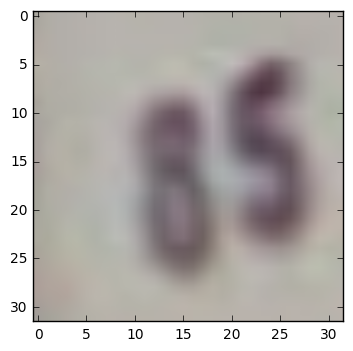

In [32]:
image_index = np.random.randint(len(train_dataset))
print(train_labels[image_index])
fig = plt.figure()
plotwindow = fig.add_subplot(111)
plt.imshow(train_dataset[image_index])
plt.show()